In [106]:
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from datetime import datetime, timedelta

from statistics import mean

**Aim: For each location in the dataset, find the 5 most locations/tourist destinations based on tourist experience and COVID situation (cases) over the last 90 days.**

In [107]:
random.seed(3888)

# Preparing the data for nearest neighbours analysis

## Data import

In [108]:
df = pd.read_csv("data/data.txt")
df = df.drop(columns='Unnamed: 0')

In [109]:
df_without_covid = df.drop(columns=['new_cases_per_million', 
                                    'new_cases_smoothed_per_million', 
                                    'stringency_index', 
                                    'positive_rate', 
                                    'human_development_index', 
                                    'international_travel_controls',
                                    'cost_living_index',
                                    'date'])

In [110]:
df_without_covid = df_without_covid.drop_duplicates()
df_without_covid = df_without_covid.reset_index()
df_without_covid = df_without_covid.drop(columns=['index'])

df_without_covid

,iso_code,location,continent,tourist_service_index
0,ALB,Albania,Europe,4.01
1,DZA,Algeria,Africa,1.84
2,ARG,Argentina,South America,4.53
3,ARM,Armenia,Asia,4.33
4,AUS,Australia,Oceania,6.06
...,...,...,...,...
111,VEN,Venezuela,South America,2.96
112,VNM,Vietnam,Asia,2.85
113,YEM,Yemen,Asia,1.87
114,ZMB,Zambia,Africa,2.52


In [111]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [112]:
covid_colnames = ['iso_code', 
                  'new_cases_smoothed_per_million',
                  'date'
                 ]

covid_needed_cols = covid[covid_colnames]

In [113]:
covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')

/tmp/ipykernel_2985/1566742333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')


In [114]:
covid_needed_cols = covid_needed_cols[covid_needed_cols['date'] >= datetime.now() - timedelta(days = 90)]

In [115]:
covid_merged = pd.merge(covid_needed_cols, df_without_covid, on="iso_code")

In [116]:
covid_merged

,iso_code,new_cases_smoothed_per_million,date,location,continent,tourist_service_index
0,ALB,508.440,2022-02-02,Albania,Europe,4.01
1,ALB,430.769,2022-02-03,Albania,Europe,4.01
2,ALB,449.814,2022-02-04,Albania,Europe,4.01
3,ALB,449.814,2022-02-05,Albania,Europe,4.01
4,ALB,441.709,2022-02-06,Albania,Europe,4.01
...,...,...,...,...,...,...
10203,ZWE,3.502,2022-04-26,Zimbabwe,Africa,2.95
10204,ZWE,3.720,2022-04-27,Zimbabwe,Africa,2.95
10205,ZWE,3.796,2022-04-28,Zimbabwe,Africa,2.95
10206,ZWE,3.351,2022-04-29,Zimbabwe,Africa,2.95


## Computing medians of quantitative columns

In [117]:
medians = covid_merged.groupby(["iso_code"]).median()

In [118]:
medians = medians.fillna(covid_merged.median())

/tmp/ipykernel_2985/3187006807.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  medians = medians.fillna(covid_merged.median())
/tmp/ipykernel_2985/3187006807.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = medians.fillna(covid_merged.median())


In [119]:
medians

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,22.0035,4.01
ARE,34.5235,5.63
ARG,112.3540,4.53
ARM,21.6590,4.33
AUS,1534.3550,6.06
...,...,...
VNM,606.3320,2.85
YEM,0.0420,1.87
ZAF,26.3995,4.30


## Min-max scaling

In [120]:
iso_code = medians.index

In [121]:
scaler = MinMaxScaler()

In [122]:
medians_scaled = scaler.fit_transform(medians)

In [123]:
medians_scaled = pd.DataFrame(medians_scaled, 
                              columns = ["new_cases_smoothed_per_million", "tourist_service_index"], 
                              index = iso_code)
medians_scaled

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,0.005579,0.458753
ARE,0.008753,0.784708
ARG,0.028486,0.563380
ARM,0.005491,0.523139
AUS,0.389020,0.871227
...,...,...
VNM,0.153729,0.225352
YEM,0.000011,0.028169
ZAF,0.006693,0.517103


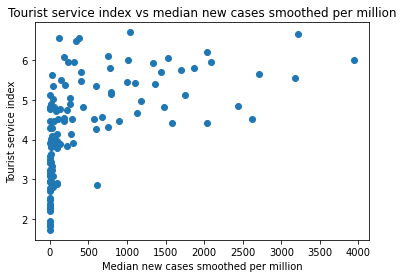

In [124]:
fig, ax = plt.subplots()

scatter = ax.scatter("new_cases_smoothed_per_million", 
                     "tourist_service_index", 
                     data = medians)


plt.title("Tourist service index vs median new cases smoothed per million")
plt.xlabel("Median new cases smoothed per million")
plt.ylabel("Tourist service index")

plt.show()

# Finding 5 nearest neighbours for each location

In [125]:
def iso_code_to_loc(iso_code):
    return iso_location[iso_location["iso_code"] == iso_code]["location"].iloc[0]

In [126]:
num_neighbours = 5

In [127]:
dist_metrics = ['euclidean', 'manhattan', 'chebyshev']

In [128]:
location_neighbours = {}

for metric in dist_metrics:
    nbrs = NearestNeighbors(metric = metric, 
                            n_neighbors = num_neighbours + 1, 
                            algorithm='ball_tree').fit(medians_scaled)
    
    nbr_indices = list(list(x) for x in nbrs.kneighbors(medians_scaled)[1])
    
    iso_location = df[["iso_code", "location"]].drop_duplicates()

    for i in range(len(nbr_indices)):
        current_iso_code = list(medians_scaled.index)[i]
        current_location = iso_code_to_loc(current_iso_code)

        neighbours = []
        for j in range(1, num_neighbours + 1):
            iso_code = medians_scaled.index[nbr_indices[i][j]]
            neighbours.append(iso_code_to_loc(iso_code))

        if not current_location in location_neighbours:
            location_neighbours[current_location] = {metric: neighbours}
        else:
            location_neighbours[current_location][metric] = neighbours

In [129]:
location_neighbours_df = pd.DataFrame(location_neighbours).transpose()

In [130]:
location_neighbours_df

,euclidean,manhattan,chebyshev
Albania,"[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Ecuador, Oman, Morocco, Lebanon, Kuwait]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]"
United Arab Emirates,"[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Montenegro, Peru, Costa Rica, Saudi Arabia, J...","[Montenegro, Costa Rica, Peru, Bulgaria, Thail..."
Argentina,"[Romania, Suriname, Brazil, Myanmar, Panama]","[Romania, Suriname, Brazil, Myanmar, Poland]","[Suriname, Brazil, Romania, Myanmar, Armenia]"
Armenia,"[South Africa, Ukraine, Myanmar, Suriname, Tun...","[South Africa, Ukraine, Myanmar, Suriname, Oman]","[South Africa, Ukraine, Myanmar, Suriname, Tun..."
Australia,"[Luxembourg, Greece, France, New Zealand, Swit...","[Luxembourg, France, Greece, New Zealand, Italy]","[Luxembourg, Greece, France, New Zealand, Slov..."
...,...,...,...
Vietnam,"[Mongolia, Moldova, Iran, Indonesia, Zimbabwe]","[Mongolia, Moldova, Iran, India, Kenya]","[Mongolia, Moldova, Indonesia, Iran, Paraguay]"
Yemen,"[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]","[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]","[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]"
South Africa,"[Armenia, Ukraine, Myanmar, Suriname, Tunisia]","[Armenia, Ukraine, Myanmar, Suriname, Oman]","[Armenia, Ukraine, Tunisia, Suriname, Myanmar]"
Zambia,"[Nigeria, Tanzania, Pakistan, Ghana, Rwanda]","[Nigeria, Tanzania, Pakistan, Ghana, Rwanda]","[Nigeria, Tanzania, Pakistan, Rwanda, Ghana]"


In [131]:
prop_sim = []

for location in location_neighbours.keys():
    ind_pairs = [[0, 1], [0, 2], [1, 2]]
    
    for pair in ind_pairs:
        loc_intersect = set(location_neighbours[location][dist_metrics[0]]).intersection(location_neighbours[location][dist_metrics[1]])
        prop_sim.append(len(loc_intersect)/num_neighbours)

In [132]:
mean(prop_sim)

0.8810344827586207